In [54]:
import numpy as np
import pandas as pd
import yfinance as yf

In [55]:
stock_symbol = 'SUNPHARMA.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [56]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,1.812932,1.804799,1.803250,1.803250,1.414609,38730
1996-01-02,1.800926,1.800926,1.743219,1.743219,1.367517,77460
1996-01-03,1.743219,1.750578,1.750578,1.750578,1.373290,12910
1996-01-04,1.746705,1.758324,1.742832,1.742832,1.367213,64550
1996-01-05,1.738572,1.738572,1.738572,1.738572,1.363871,12910
...,...,...,...,...,...,...
2024-04-25,1490.000000,1527.300049,1488.650024,1520.150024,1520.150024,3846327
2024-04-26,1531.000000,1532.000000,1500.050049,1506.550049,1506.550049,1794350
2024-04-29,1516.000000,1527.800049,1510.050049,1521.599976,1521.599976,1091667


In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [58]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [59]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [60]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 9s 12ms/step - loss: 0.0025
Epoch 2/50
221/221 [==============================] - 3s 12ms/step - loss: 9.2849e-04
Epoch 3/50
221/221 [==============================] - 3s 12ms/step - loss: 8.1072e-04
Epoch 4/50
221/221 [==============================] - 3s 15ms/step - loss: 7.7308e-04
Epoch 5/50
221/221 [==============================] - 3s 14ms/step - loss: 7.4021e-04
Epoch 6/50
221/221 [==============================] - 3s 12ms/step - loss: 6.3882e-04
Epoch 7/50
221/221 [==============================] - 3s 15ms/step - loss: 6.4216e-04
Epoch 8/50
221/221 [==============================] - 5s 23ms/step - loss: 6.3844e-04
Epoch 9/50
221/221 [==============================] - 3s 12ms/step - loss: 5.8240e-04
Epoch 10/50
221/221 [==============================] - 3s 12ms/step - loss: 5.6190e-04
Epoch 11/50
221/221 [==============================] - 3s 12ms/step - loss: 5.7256e-04
Epoch 12/50
221/221 [==============================] - 3

1/1 [==============================] - 0s 26ms/step


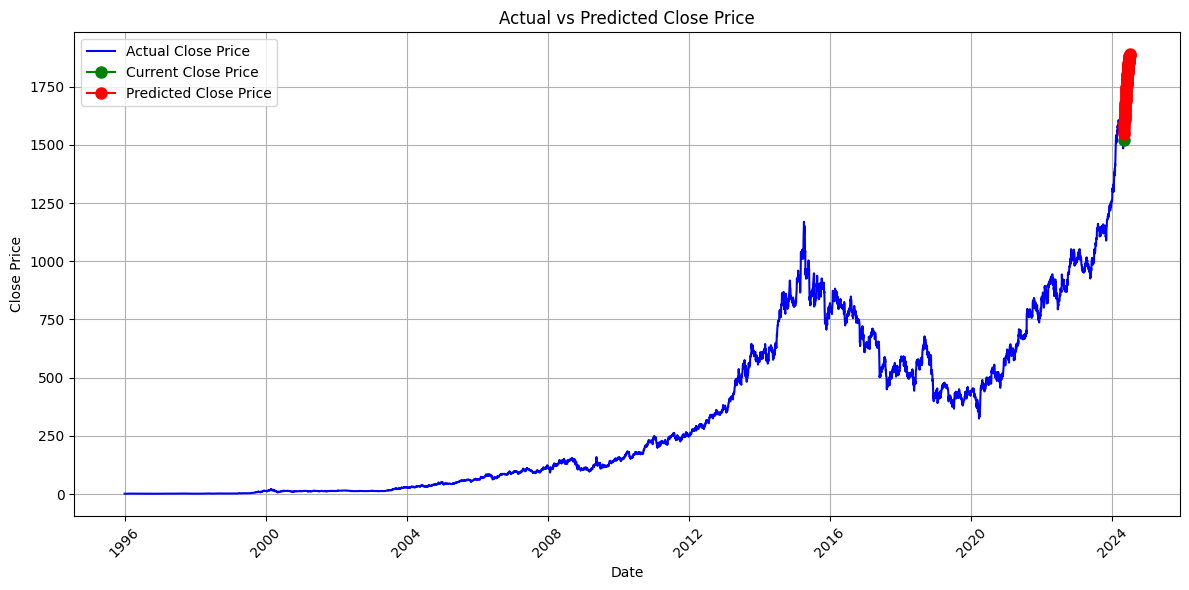

In [61]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
predicted_prices

array([1547.5598, 1557.0132, 1570.148 , 1583.4921, 1595.541 , 1605.944 ,
       1614.8748, 1622.7047, 1629.8345, 1636.6115, 1643.298 , 1650.0656,
       1657.0029, 1664.1337, 1671.4332, 1678.8479, 1686.3107, 1693.7528,
       1701.1139, 1708.3457, 1715.4153, 1722.3041, 1729.0054, 1735.5226,
       1741.8647, 1748.0443, 1754.0746, 1759.9672, 1765.7319, 1771.3757,
       1776.9023, 1782.3138, 1787.6102, 1792.7903, 1797.8523, 1802.7949,
       1807.617 , 1812.3177, 1816.8978, 1821.3578, 1825.6995, 1829.9247,
       1834.0359, 1838.0356, 1841.9261, 1845.7101, 1849.3899, 1852.9675,
       1856.4453, 1859.8253, 1863.1094, 1866.2993, 1869.3973, 1872.4052,
       1875.3247, 1878.1581, 1880.907 , 1883.5737, 1886.16  , 1888.668 ],
      dtype=float32)

In [63]:
model.save('SUNPHARMA.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
import joblib
joblib.dump(scaler, 'SUNPHARMA_minmax_scaler.pkl')

['SUNPHARMA_minmax_scaler.pkl']